**使用resnet模型进行图像分类**

**1、基本残差块的思想**

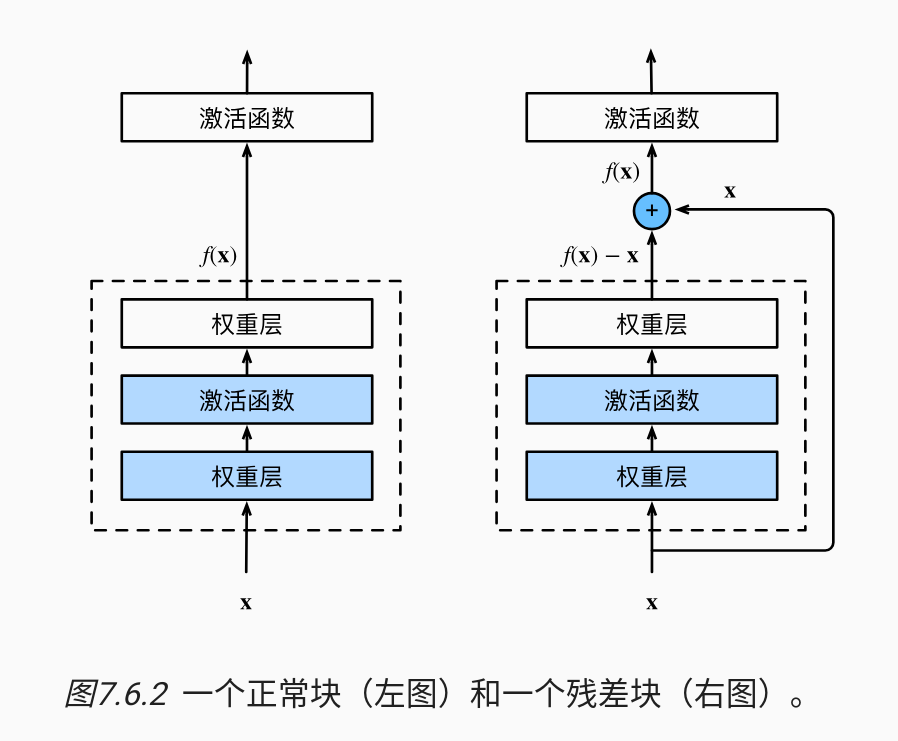

**2、将输入跨越块往后传播就需要确保块的输入与输出形状一致，这个要求限制了块的能力，但是可以通过在跨层传播数据通路中增加1x1卷积层即可改变通道维度，增加了块的灵活性，块的架构如下**

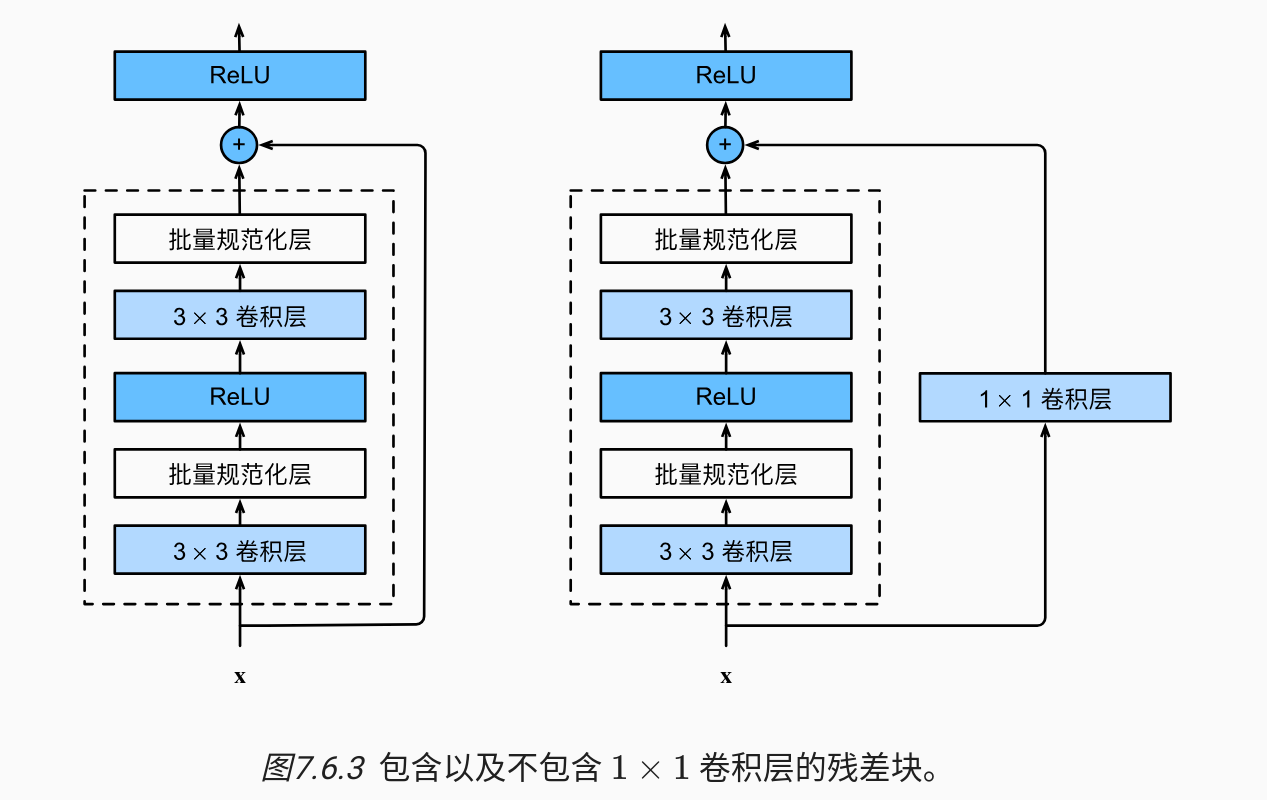

**3、resnet18整体架构**

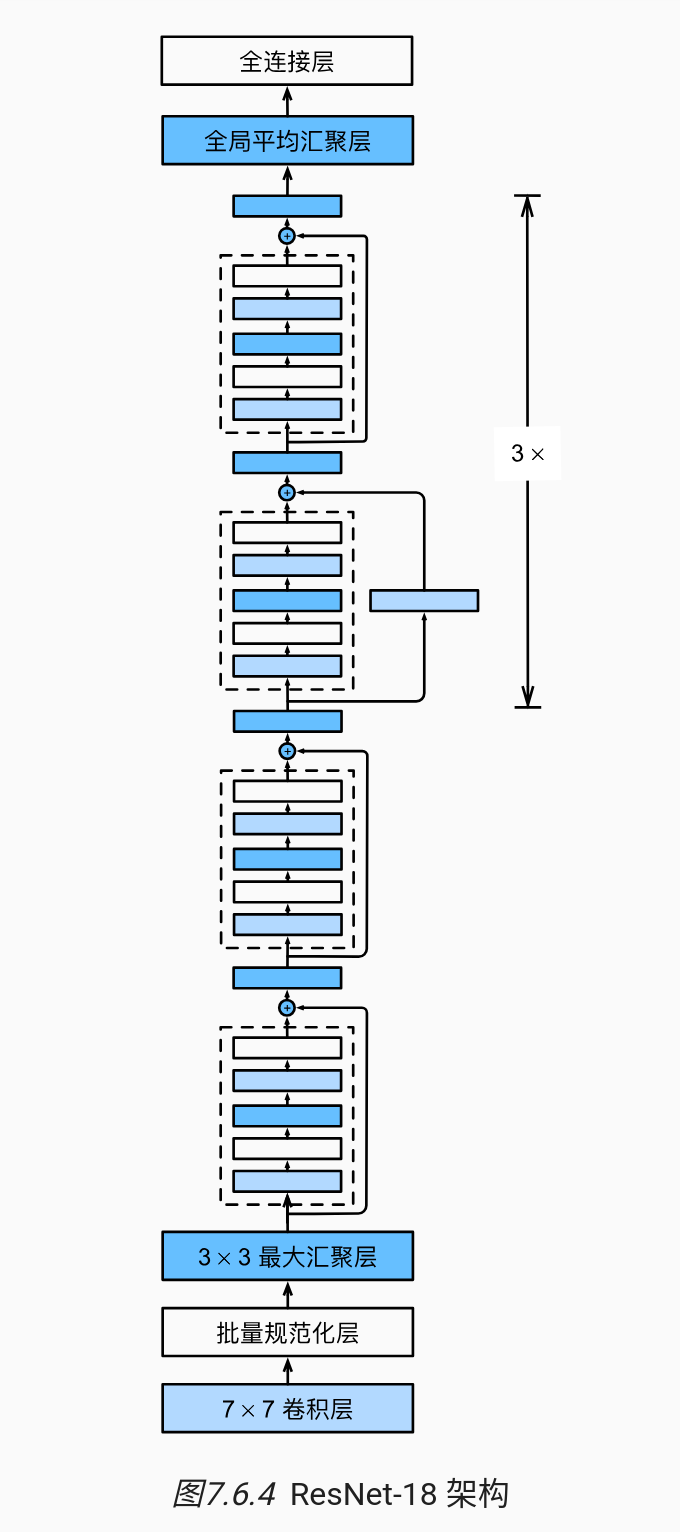

**一、数据预处理**

In [1]:
from frame_special import *
import numpy as np
import torchinfo

In [2]:
# 加载原始数据
train_arrays,train_labels = load_data()
test_arrays = load_test()

Load train data:   0%|          | 0/50000 [00:00<?, ?it/s]

Load test data: 100%|██████████| 300000/300000 [00:23<00:00, 12760.02it/s]


In [3]:
# 构造训练数据迭代器
batch_size = 64
train_dataset = TrainDataset(train_arrays,train_labels)
train_iter = data.DataLoader(train_dataset,batch_size,shuffle = True)

Load-Data-iter: 100%|██████████| 50000/50000 [00:03<00:00, 15808.85it/s]

load 50000 images!


In [4]:
# 构造测试数据迭代器
test_dataset = TestDataset(test_arrays)
test_iter = data.DataLoader(test_dataset,batch_size,shuffle = False)

Load-Data-iter: 100%|██████████| 300000/300000 [00:20<00:00, 14562.23it/s]

load 300000 images!


**二、resnet18模型搭建**

In [5]:
class Residual(nn.Module):
    """实现单个残差块"""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [6]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    """生成单个残差块"""
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk


In [7]:
def resnet18(in_channels,class_nums):
    """生成resnet18网络"""
    b1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
    b3 = nn.Sequential(*resnet_block(64, 128, 2))
    b4 = nn.Sequential(*resnet_block(128, 256, 2))
    b5 = nn.Sequential(*resnet_block(256, 512, 2))
    return nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)), # 全局池化(N,C,H,W) -> (N,C,1,1)
                    nn.Flatten(), nn.Linear(512, class_nums))

In [8]:
net = resnet18(in_channels = 3,class_nums = 10)
input = torch.rand((64,3,32,32))
print(torchinfo.summary(net,input.shape))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 10]                  --
├─Sequential: 1-1                        [64, 64, 8, 8]            --
│    └─Conv2d: 2-1                       [64, 64, 16, 16]          9,472
│    └─BatchNorm2d: 2-2                  [64, 64, 16, 16]          128
│    └─ReLU: 2-3                         [64, 64, 16, 16]          --
│    └─MaxPool2d: 2-4                    [64, 64, 8, 8]            --
├─Sequential: 1-2                        [64, 64, 8, 8]            --
│    └─Residual: 2-5                     [64, 64, 8, 8]            --
│    │    └─Conv2d: 3-1                  [64, 64, 8, 8]            36,928
│    │    └─BatchNorm2d: 3-2             [64, 64, 8, 8]            128
│    │    └─Conv2d: 3-3                  [64, 64, 8, 8]            36,928
│    │    └─BatchNorm2d: 3-4             [64, 64, 8, 8]            128
│    └─Residual: 2-6                     [64, 64, 8, 8]            --
│

**三、模型训练**

In [11]:
# 定义超参数
num_epochs = 10
lr = 0.01

# 损失函数
loss_fn = nn.CrossEntropyLoss()

In [17]:
device = try_gpu(i = 0)
loss_plt = train(net,train_iter,lr,num_epochs,loss_fn,device)

Epoch [10/10]: 100%|██████████| 782/782 [00:23<00:00, 33.17it/s, LOSS=0.00333, lr=1.000000e-02]


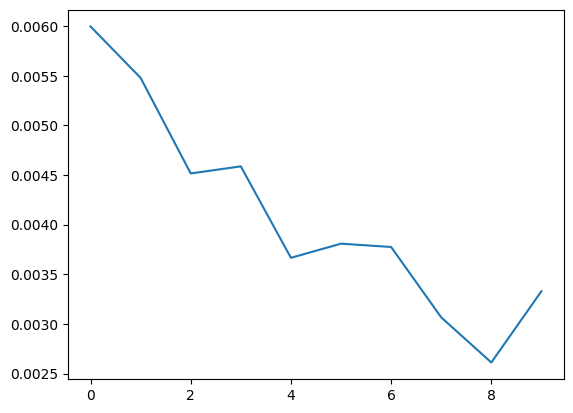

In [18]:
# 训练损失展示
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_plt)),loss_plt)
plt.show()

In [19]:
# 保存模型
torch.save(net,"models/resnet18-4.pt")
print(f"model save successfully!")

model save successfully!


**四、模型评估**

In [20]:
net = torch.load("models/resnet18-4.pt",weights_only = False) # 微调后的新模型
acc = count_accurancy(net,train_iter)
print(acc)

Eval: 100%|██████████| 782/782 [00:03<00:00, 222.80it/s]

0.94252


In [21]:
# 在验证集上测试
predict(net,test_iter,train_dataset.idx2obj)

Predict: 100%|██████████| 4688/4688 [00:18<00:00, 257.54it/s]
